## Problem

Na raspolaganju nam je skup podataka o pacijentima koji su imali uspešnu terapiju elektrokonverzijom. Naš zadatak je da napravimo klasifikacioni model koji predviđa da li će se sinusni ritam rada srca pacijenta održati i nakon godinu dana od terapije.
Kako su se Bajesovske mreže pokazale neadekvatno, primenjivaćemo metode potpornih vektora, drveta odlučivanja, neuronskih mreža i naivnog Bajesa.

## Učitavanje podataka

Podaci su dimenzije 130 x 69. Redovi predstavljaju pacijente, a atributi su karakteristike zdravstvenog stanja pacijenata i primenjena terapija pre i nakon elektorkonverzije.
Ulazni atributi su celobrojnog tipa, a ciljni atribut istinitosnog tipa. Ciljni atribut predstavlja uspešnost održavanja sinusnog ritma nakon godinu dana.
U skupu nisu jednako zastupljene klase False i True, ali je odnos približno 60:40.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('PodaciZaKlasifikaciju.csv', index_col=0)
data

,Broj,godine starosti,stariji od 65,Pol,indikacija: perzistentna,ukupno trajanje AF (kada je prvi put dijagnostikovana) u mesecima,trajanje ove epizode AF u mesecima,frekvenca komora na prijemnom EKG-u,Blok grane,dimenzija LPK,...,Amiodaron.1,Propafen.1,Flekainid.1,Sotalol.1,Digoksin.1,ASA.1,OAKT.1,Plavix.1,Statin.1,Održavanje sinusnog ritma nakon godinu dana
0,1,78,1,1,1,5,5,0,3,42,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
1,2,61,0,1,2,24,1,7,0,42,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
2,3,65,1,1,1,4,4,0,3,47,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
3,4,64,0,1,1,288,2,7,0,50,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
4,5,65,1,2,1,48,3,9,0,49,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,646,61,0,1,2,2,2,0,3,36,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
143,647,58,0,1,2,12,2,0,3,45,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,True
144,648,72,1,2,1,20,20,6,0,43,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,False
145,649,39,0,1,2,48,1,9,0,35,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,True


## Funkcija za klasifikaciju podataka odredjenim modelom

### Podela podataka na skup za trening i skup za test

Skup podataka delimo na skup za trening modela i skup za testiranje modela.
Argument random_state ima vrednost 0 da bi se svaku put dobio isto podeljen skup, kako bismo mogli da upoređujemo modele. Argument stratifz ima vrednost ciljne promenljive kako bi raspodela podataka u trening i test skupu ostala probližno ista kao u početnom skupu.

### Procena kvaliteta modela

Prilikom procene kvaliteta modela razmatraćemo izveštaj klasifikacije, matricu konfuzije (koja u vidu toplotne mape prikazuje koliko je elemenata koje klase dobro klasifikovano, a koliko loše), i ROC krivu (površina ispod krive je mera uspeha binarnog klasifikatora).

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, classification_report, plot_confusion_matrix

In [4]:
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

In [5]:
def klasifikuj(X, Y, model):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, stratify=Y, test_size=0.3)
    
    model.fit(X_train, Y_train)
    
    Y_pred = model.predict(X_test)
    print(classification_report(Y_test, Y_pred))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    
    plot_confusion_matrix(model, X_test, Y_test, ax=ax1, cmap=plt.cm.Blues, colorbar=False)
    ax1.set_xlabel('Predviđeno')
    ax1.set_ylabel('Stvarno')
    ax1.set_title('Matrica konfuzije')
    
    plot_roc_curve(model, X_test, Y_test, pos_label=False, lw=3, color='orange', ax=ax2)
    ax2.set_xlabel('Stopa lažno neuspešnih')
    ax2.set_ylabel('Stopa stvarno neuspešnih')
    ax2.set_title('ROC kriva neuspešnih')
    ax2.legend(loc='lower right')
    
    plt.show() 
    
    return model
    
    

## Primena različitih klasifikatora

## Metod potpornih vektora

Glavna suština modela je određivanje maksimalne margine hiperravni koja razdvaja podatke na dva skupa. Primenićemo nelinearni SVM (SVC u sklearn-u).

Parametri SVC klasifikatora:<br>
**C** - regularizacioni parametar <br>
**kernel** - tip kernel funkcije za transformaciju prostora <br>
**gamma** - koeficijent kernel funkcije <br>
**coef0** - koeficijent kernel funkcije <br>
**degree** - koeficijent kernel funkcije (samo za 'poly') <br>

Prilikom izbora parametara koristićemo funkciju GridSearchCV.
Za funkciju ocenjivanja modela prilikom nalaženja najboljih parametara, biće korišćeni balansirana tačnost i površina ispod ROC krive.

U Nastavku je prikazan izbor najboljih parametara, a zatim i primena modela korišćenjem tih parametara nad neskaliranim i sklairanim podacima.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC(random_state=0,
          class_weight='balanced')

params = [{
   'C':[0.1,0.3,0.5,0.7,1.0],
   'kernel': ['linear','poly','rbf','sigmoid'],   
   'gamma':['scale','auto'],
   'coef0':[0.2,0.3,0.5,0.7,0.9],
   'degree':[1,2,3,4,5,6,7],
}]

gscv = GridSearchCV(estimator=clf, 
                    param_grid=params, 
                    cv=3,
                    refit='balanced_accuracy', 
                    scoring= ['balanced_accuracy','roc_auc'])

X_train, _, Y_train, _ = train_test_split(X, Y, random_state=0, stratify=Y, test_size=0.3)    
gscv.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced', random_state=0),
             param_grid=[{'C': [0.1, 0.3, 0.5, 0.7, 1.0],
                          'coef0': [0.2, 0.3, 0.5, 0.7, 0.9],
                          'degree': [1, 2, 3, 4, 5, 6, 7],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'roc_auc'])

In [7]:
print(gscv.best_score_)
gscv.best_params_

0.6548378522062733


{'C': 0.3, 'coef0': 0.2, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}

              precision    recall  f1-score   support

       False       0.68      0.62      0.65        24
        True       0.47      0.53      0.50        15

    accuracy                           0.59        39
   macro avg       0.58      0.58      0.58        39
weighted avg       0.60      0.59      0.59        39

[0.         0.         0.06666667 0.06666667 0.2        0.2
 0.33333333 0.33333333 0.4        0.4        0.46666667 0.46666667
 0.53333333 0.53333333 0.66666667 0.66666667 0.73333333 0.73333333
 0.86666667 0.86666667 1.        ]
[0.         0.04166667 0.04166667 0.33333333 0.33333333 0.375
 0.375      0.41666667 0.41666667 0.45833333 0.45833333 0.66666667
 0.66666667 0.75       0.75       0.91666667 0.91666667 0.95833333
 0.95833333 1.         1.        ]


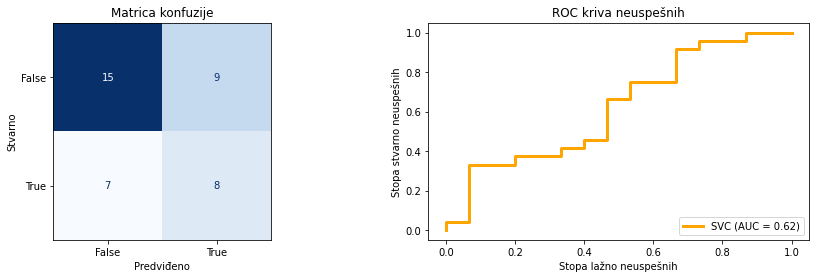

SVC(C=0.3, coef0=0.2, degree=1, kernel='linear', probability=True)

In [8]:
model = SVC(C=0.3, 
            coef0=0.2, 
            degree=1,
            gamma='scale',
            kernel='linear', 
           probability=True)
klasifikuj(X, Y, model)

              precision    recall  f1-score   support

       False       0.59      0.67      0.63        24
        True       0.33      0.27      0.30        15

    accuracy                           0.51        39
   macro avg       0.46      0.47      0.46        39
weighted avg       0.49      0.51      0.50        39

[0.         0.         0.06666667 0.06666667 0.2        0.2
 0.4        0.4        0.46666667 0.46666667 0.6        0.6
 0.73333333 0.73333333 1.        ]
[0.         0.04166667 0.04166667 0.125      0.125      0.29166667
 0.29166667 0.33333333 0.33333333 0.58333333 0.58333333 0.625
 0.625      1.         1.        ]


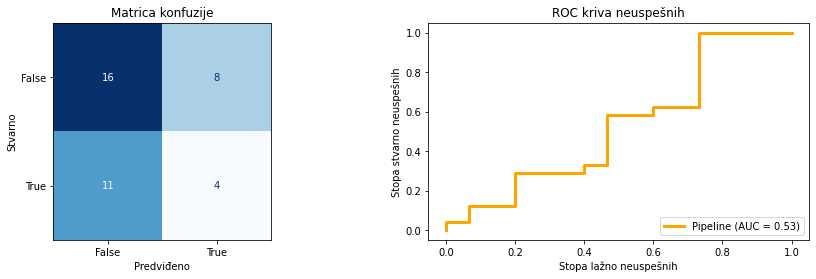

Pipeline(steps=[('std', StandardScaler()),
                ('model',
                 SVC(C=0.3, coef0=0.2, degree=1, kernel='linear',
                     probability=True))])

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = Pipeline([('std', StandardScaler()), ('model', model)])
klasifikuj(X, Y, model)

## Stablo odlučivanja

Prilikom klasifikacije upotrebom stabla odlučivanja, formia se setablo čiji svaki unutrašnji čvor sadrši pitanje za određeni atribut. Na osnovu pitanja u čvorovima pretraga se usmerava do listovakoji određuju klasu instance koja se klasifikuje. Prvobitno će svakoj klasi odgovarati težina obrnuto srazmerna njenoj zastupljenosti u skupu.

              precision    recall  f1-score   support

       False       0.65      0.83      0.73        24
        True       0.50      0.27      0.35        15

    accuracy                           0.62        39
   macro avg       0.57      0.55      0.54        39
weighted avg       0.59      0.62      0.58        39

[0.         0.73333333 1.        ]
[0.         0.83333333 1.        ]


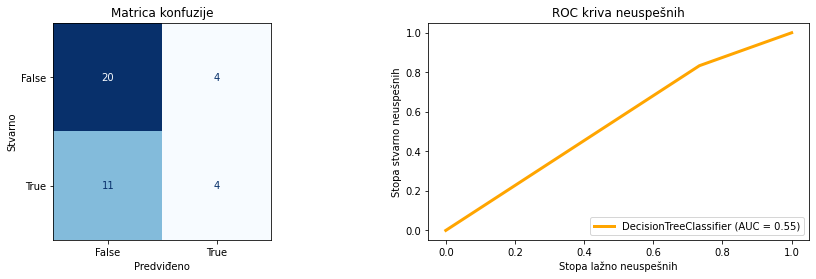

DecisionTreeClassifier(class_weight='balanced', random_state=0)

In [10]:
from sklearn.tree import DecisionTreeClassifier

model1 =  DecisionTreeClassifier(random_state=0, class_weight='balanced')

klasifikuj(X, Y, model1)

### Skraćivanje stabla

Pokušaćemo da poboljšamo model skraćivanjem stabla, odnosno odsecanjem dela stabla. Stablo skracujemo u odnosu na vrednost parametra ccp_alpha. Što je vrednost parametra veća, veće će biti odsecanje.

U nastvaku su prikazane različite vrednosti parametra ccp_alpha i kako one utiču na nečistoću listova.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

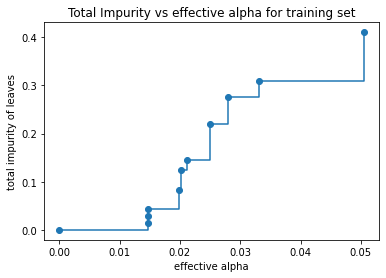

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, stratify=Y, test_size=0.3)    

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Isprobali smo različite vrednosti parametra ccp_alpha i možemo da zaključimo da se skraćivanjem stabla ne dobija bolji model. 

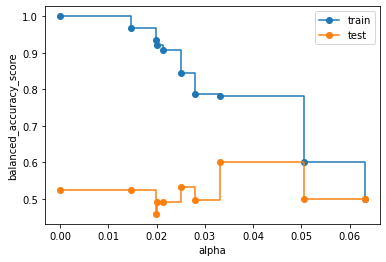

In [12]:
ccp_alphas = np.unique(ccp_alphas)
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, Y_train)
    clfs.append(clf)
    

from sklearn.metrics import balanced_accuracy_score

# clfs = clfs[:-1]
# ccp_alphas = ccp_alphas[:-1]
train_scores = [balanced_accuracy_score(Y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [balanced_accuracy_score(Y_test, clf.predict(X_test)) for clf in clfs]

plt.xlabel('alpha')
plt.ylabel('balanced_accuracy_score')
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
plt.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
plt.legend()

plt.show()

### Težine klasa

Ako težine klasa ne bi bile balansirane, dobili bismo model kao u nastavku.
Model je sličan prethodnom modelu, samo je ovog puta druga klasa lošije prepoznata. Probali smo da promenimo težine klasa, ali dobijeni rezultati su bili isti ili gori, pa to nećemo ni prikazati.

              precision    recall  f1-score   support

       False       0.64      0.58      0.61        24
        True       0.41      0.47      0.44        15

    accuracy                           0.54        39
   macro avg       0.52      0.53      0.52        39
weighted avg       0.55      0.54      0.54        39

[0.         0.53333333 1.        ]
[0.         0.58333333 1.        ]


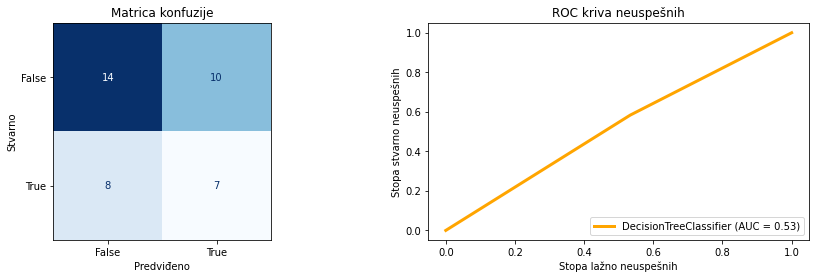

DecisionTreeClassifier(random_state=0)

In [13]:
model2 = DecisionTreeClassifier(random_state=0)
klasifikuj(X, Y, model2)

## Slučajna šuma

Ovaj metod klasifikacije predstavlja kombinaciju različitih stabala odlučivanja, koja odgovaraju različitim delovima skupa podataka.
Poredili smo više klasifikatora za različite vrednosti parametara n_estimators i max_samples i dobili najbolji model za vrednosti parametara n_estimators=10 , max:sampples=20.

n_estimators: 2 , max_samples:5
              precision    recall  f1-score   support

       False       0.64      0.75      0.69        24
        True       0.45      0.33      0.38        15

    accuracy                           0.59        39
   macro avg       0.55      0.54      0.54        39
weighted avg       0.57      0.59      0.57        39

[0.         0.06666667 0.66666667 1.        ]
[0.         0.20833333 0.75       1.        ]


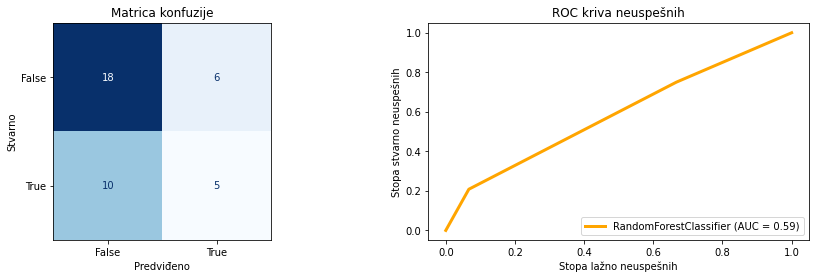

n_estimators: 2 , max_samples:10
              precision    recall  f1-score   support

       False       0.67      1.00      0.80        24
        True       1.00      0.20      0.33        15

    accuracy                           0.69        39
   macro avg       0.83      0.60      0.57        39
weighted avg       0.79      0.69      0.62        39

[0.         0.46666667 0.8        1.        ]
[0.         0.41666667 1.         1.        ]


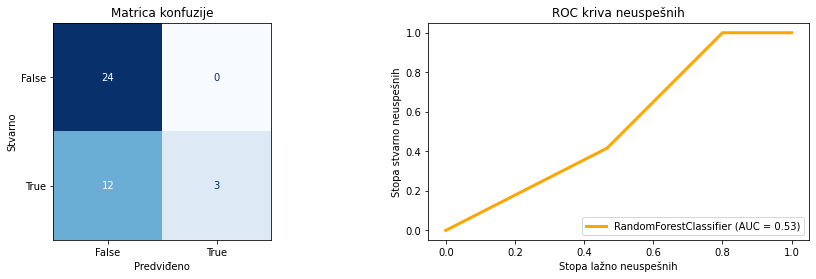

n_estimators: 2 , max_samples:15
              precision    recall  f1-score   support

       False       0.57      0.83      0.68        24
        True       0.00      0.00      0.00        15

    accuracy                           0.51        39
   macro avg       0.29      0.42      0.34        39
weighted avg       0.35      0.51      0.42        39

[0.         0.26666667 1.         1.        ]
[0.         0.45833333 0.83333333 1.        ]


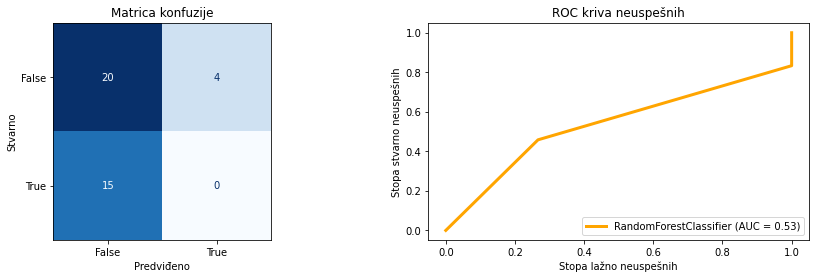

n_estimators: 2 , max_samples:20
              precision    recall  f1-score   support

       False       0.60      0.88      0.71        24
        True       0.25      0.07      0.11        15

    accuracy                           0.56        39
   macro avg       0.42      0.47      0.41        39
weighted avg       0.47      0.56      0.48        39

[0.         0.2        0.93333333 1.        ]
[0.    0.625 0.875 1.   ]


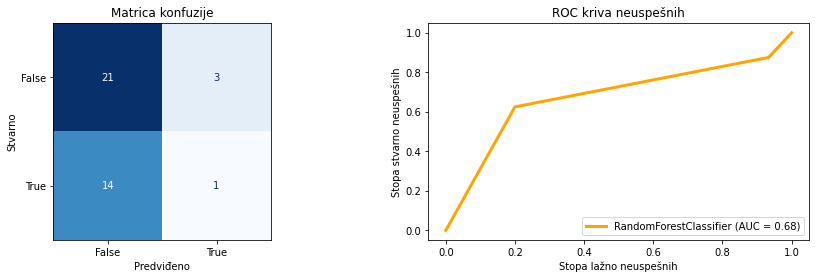

n_estimators: 2 , max_samples:25
              precision    recall  f1-score   support

       False       0.69      0.92      0.79        24
        True       0.71      0.33      0.45        15

    accuracy                           0.69        39
   macro avg       0.70      0.62      0.62        39
weighted avg       0.70      0.69      0.66        39

[0.         0.26666667 0.66666667 1.        ]
[0.         0.29166667 0.91666667 1.        ]


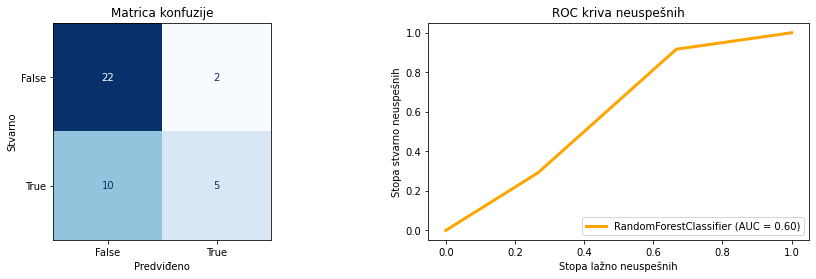

n_estimators: 2 , max_samples:50
              precision    recall  f1-score   support

       False       0.63      0.71      0.67        24
        True       0.42      0.33      0.37        15

    accuracy                           0.56        39
   macro avg       0.52      0.52      0.52        39
weighted avg       0.55      0.56      0.55        39

[0.         0.4        0.66666667 1.        ]
[0.         0.25       0.70833333 1.        ]


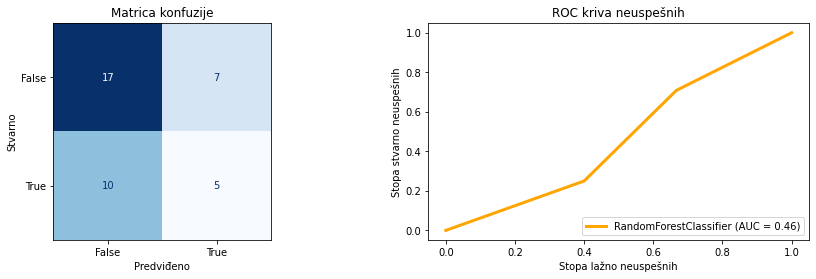

n_estimators: 2 , max_samples:75
              precision    recall  f1-score   support

       False       0.61      0.83      0.70        24
        True       0.33      0.13      0.19        15

    accuracy                           0.56        39
   macro avg       0.47      0.48      0.45        39
weighted avg       0.50      0.56      0.51        39

[0.         0.26666667 0.86666667 1.        ]
[0.         0.41666667 0.83333333 1.        ]


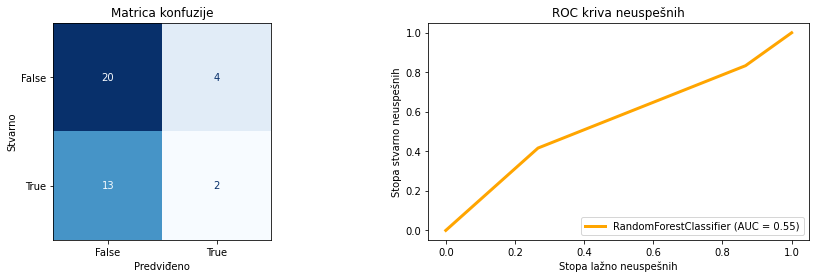

n_estimators: 2 , max_samples:91
              precision    recall  f1-score   support

       False       0.70      0.96      0.81        24
        True       0.83      0.33      0.48        15

    accuracy                           0.72        39
   macro avg       0.77      0.65      0.64        39
weighted avg       0.75      0.72      0.68        39

[0.         0.46666667 0.66666667 1.        ]
[0.         0.5        0.95833333 1.        ]


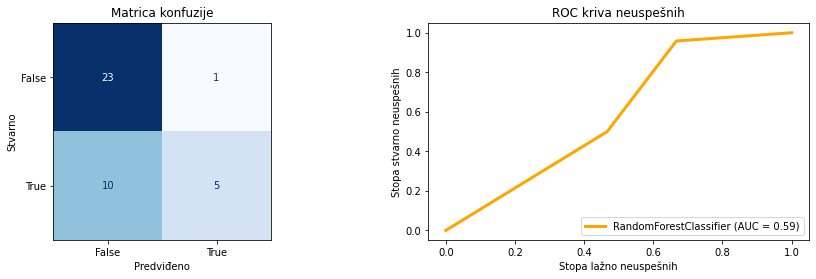

n_estimators: 5 , max_samples:5
              precision    recall  f1-score   support

       False       0.71      0.21      0.32        24
        True       0.41      0.87      0.55        15

    accuracy                           0.46        39
   macro avg       0.56      0.54      0.44        39
weighted avg       0.60      0.46      0.41        39

[0.         0.13333333 0.53333333 0.93333333 1.        ]
[0.         0.20833333 0.5        0.91666667 1.        ]


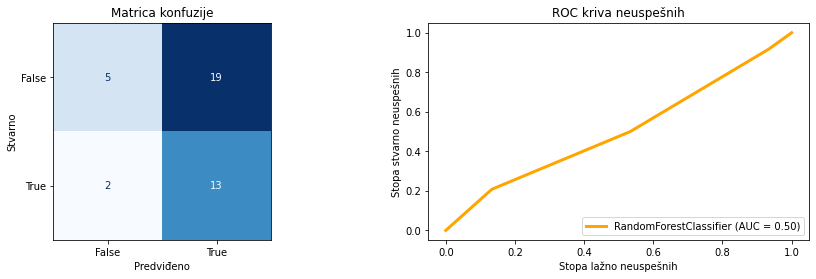

n_estimators: 5 , max_samples:10
              precision    recall  f1-score   support

       False       0.61      0.58      0.60        24
        True       0.38      0.40      0.39        15

    accuracy                           0.51        39
   macro avg       0.49      0.49      0.49        39
weighted avg       0.52      0.51      0.52        39

[0.         0.13333333 0.46666667 0.6        0.86666667 1.        ]
[0.         0.125      0.375      0.58333333 1.         1.        ]


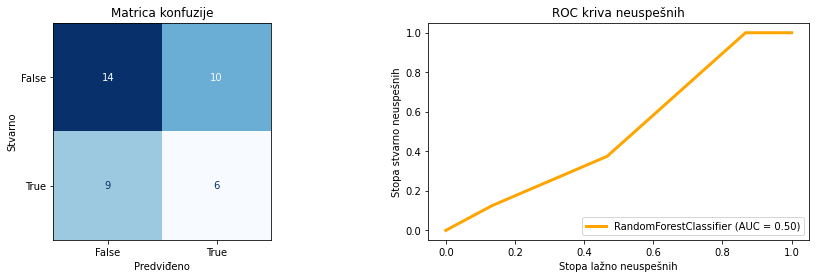

n_estimators: 5 , max_samples:15
              precision    recall  f1-score   support

       False       0.64      0.58      0.61        24
        True       0.41      0.47      0.44        15

    accuracy                           0.54        39
   macro avg       0.52      0.53      0.52        39
weighted avg       0.55      0.54      0.54        39

[0.         0.         0.13333333 0.53333333 0.93333333 1.        ]
[0.         0.08333333 0.375      0.58333333 0.875      1.        ]


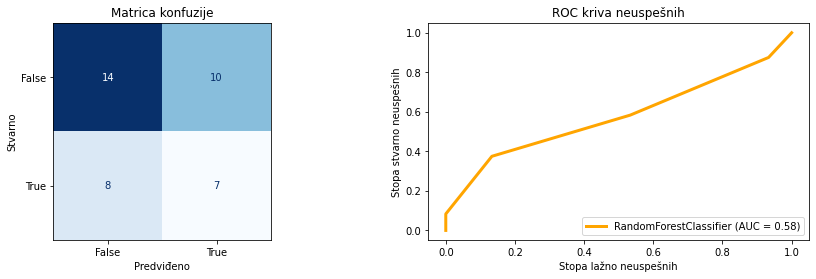

n_estimators: 5 , max_samples:20
              precision    recall  f1-score   support

       False       0.68      0.79      0.73        24
        True       0.55      0.40      0.46        15

    accuracy                           0.64        39
   macro avg       0.61      0.60      0.60        39
weighted avg       0.63      0.64      0.63        39

[0.         0.06666667 0.4        0.6        1.         1.        ]
[0.         0.04166667 0.45833333 0.79166667 0.95833333 1.        ]


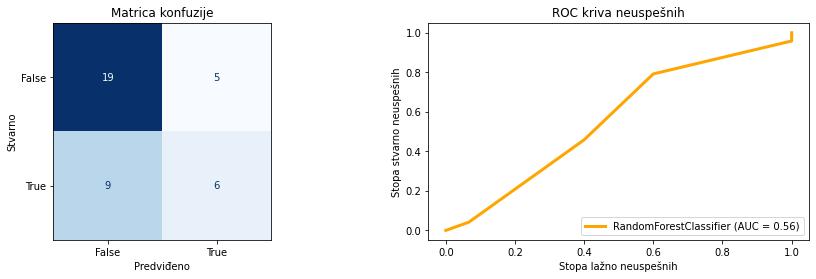

n_estimators: 5 , max_samples:25
              precision    recall  f1-score   support

       False       0.69      0.83      0.75        24
        True       0.60      0.40      0.48        15

    accuracy                           0.67        39
   macro avg       0.64      0.62      0.62        39
weighted avg       0.66      0.67      0.65        39

[0.         0.06666667 0.26666667 0.6        1.         1.        ]
[0.         0.         0.41666667 0.83333333 0.95833333 1.        ]


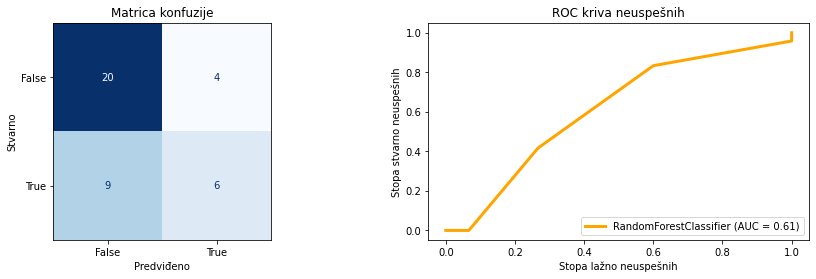

n_estimators: 5 , max_samples:50
              precision    recall  f1-score   support

       False       0.58      0.62      0.60        24
        True       0.31      0.27      0.29        15

    accuracy                           0.49        39
   macro avg       0.44      0.45      0.44        39
weighted avg       0.47      0.49      0.48        39

[0.         0.06666667 0.26666667 0.73333333 0.86666667 0.93333333
 1.        ]
[0.         0.04166667 0.33333333 0.625      0.83333333 0.95833333
 1.        ]


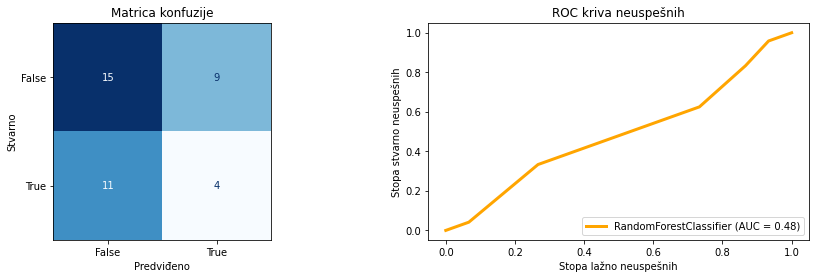

n_estimators: 5 , max_samples:75
              precision    recall  f1-score   support

       False       0.71      0.62      0.67        24
        True       0.50      0.60      0.55        15

    accuracy                           0.62        39
   macro avg       0.61      0.61      0.61        39
weighted avg       0.63      0.62      0.62        39

[0.         0.13333333 0.26666667 0.4        0.8        0.86666667
 1.        ]
[0.         0.16666667 0.29166667 0.625      0.91666667 1.
 1.        ]


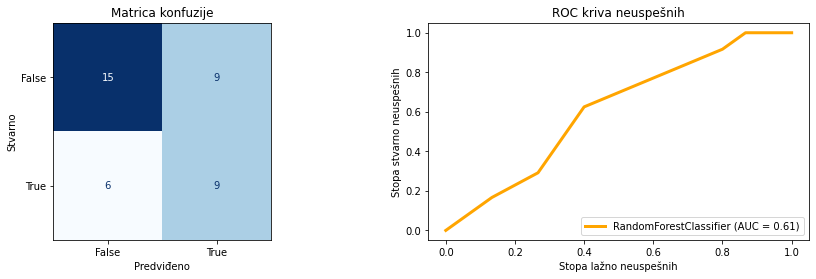

n_estimators: 5 , max_samples:91
              precision    recall  f1-score   support

       False       0.62      0.75      0.68        24
        True       0.40      0.27      0.32        15

    accuracy                           0.56        39
   macro avg       0.51      0.51      0.50        39
weighted avg       0.54      0.56      0.54        39

[0.         0.13333333 0.46666667 0.73333333 0.93333333 1.        ]
[0.         0.125      0.58333333 0.75       1.         1.        ]


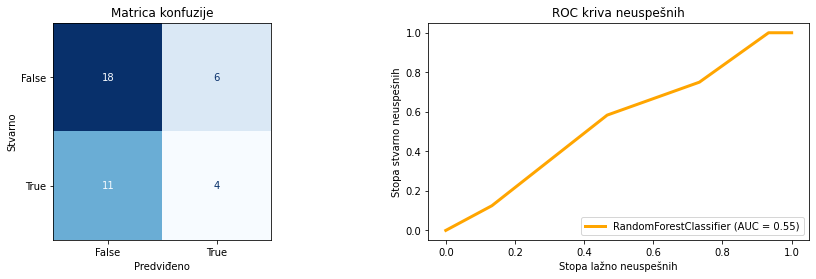

n_estimators: 10 , max_samples:5
              precision    recall  f1-score   support

       False       0.75      0.12      0.21        24
        True       0.40      0.93      0.56        15

    accuracy                           0.44        39
   macro avg       0.57      0.53      0.39        39
weighted avg       0.62      0.44      0.35        39

[0.         0.         0.06666667 0.26666667 0.53333333 0.93333333
 1.        ]
[0.         0.08333333 0.125      0.41666667 0.79166667 0.95833333
 1.        ]


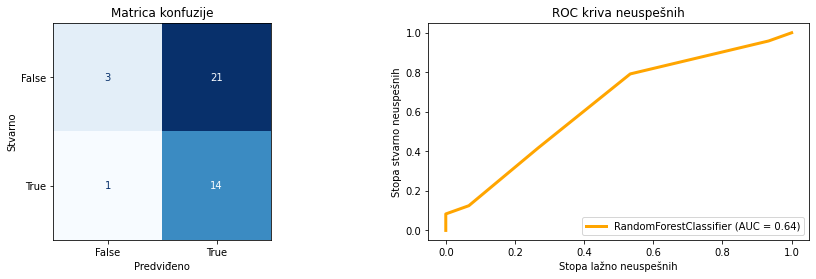

n_estimators: 10 , max_samples:10
              precision    recall  f1-score   support

       False       0.67      0.75      0.71        24
        True       0.50      0.40      0.44        15

    accuracy                           0.62        39
   macro avg       0.58      0.57      0.58        39
weighted avg       0.60      0.62      0.61        39

[0.         0.         0.06666667 0.46666667 0.6        0.6
 0.8        0.93333333 1.        ]
[0.         0.04166667 0.04166667 0.16666667 0.41666667 0.75
 0.875      1.         1.        ]


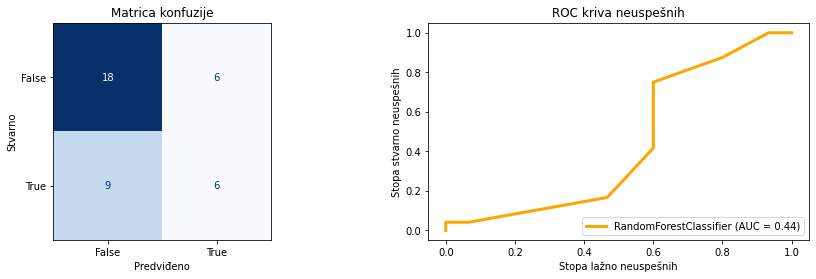

n_estimators: 10 , max_samples:15
              precision    recall  f1-score   support

       False       0.65      0.62      0.64        24
        True       0.44      0.47      0.45        15

    accuracy                           0.56        39
   macro avg       0.54      0.55      0.54        39
weighted avg       0.57      0.56      0.57        39

[0.         0.         0.26666667 0.53333333 0.73333333 0.93333333
 1.        ]
[0.         0.08333333 0.33333333 0.625      0.91666667 1.
 1.        ]


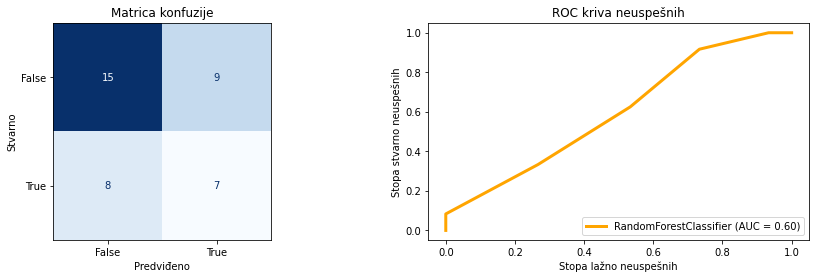

n_estimators: 10 , max_samples:20
              precision    recall  f1-score   support

       False       0.65      0.71      0.68        24
        True       0.46      0.40      0.43        15

    accuracy                           0.59        39
   macro avg       0.56      0.55      0.55        39
weighted avg       0.58      0.59      0.58        39

[0.         0.06666667 0.13333333 0.26666667 0.4        0.6
 0.8        0.93333333 1.        ]
[0.         0.         0.08333333 0.25       0.58333333 0.70833333
 0.875      0.95833333 1.        ]


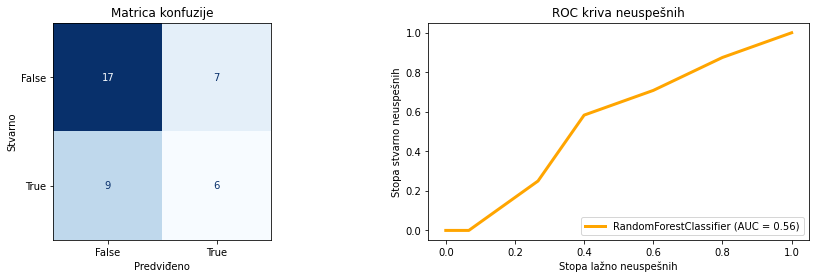

n_estimators: 10 , max_samples:25
              precision    recall  f1-score   support

       False       0.68      0.79      0.73        24
        True       0.55      0.40      0.46        15

    accuracy                           0.64        39
   macro avg       0.61      0.60      0.60        39
weighted avg       0.63      0.64      0.63        39

[0.         0.06666667 0.13333333 0.26666667 0.6        0.86666667
 1.        ]
[0.         0.08333333 0.33333333 0.66666667 0.79166667 0.91666667
 1.        ]


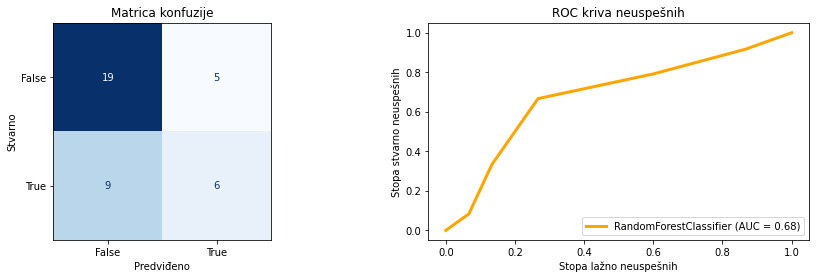

n_estimators: 10 , max_samples:50
              precision    recall  f1-score   support

       False       0.65      0.83      0.73        24
        True       0.50      0.27      0.35        15

    accuracy                           0.62        39
   macro avg       0.57      0.55      0.54        39
weighted avg       0.59      0.62      0.58        39

[0.         0.06666667 0.06666667 0.13333333 0.46666667 0.73333333
 0.73333333 0.86666667 1.         1.        ]
[0.         0.         0.04166667 0.04166667 0.41666667 0.58333333
 0.83333333 0.91666667 0.95833333 1.        ]


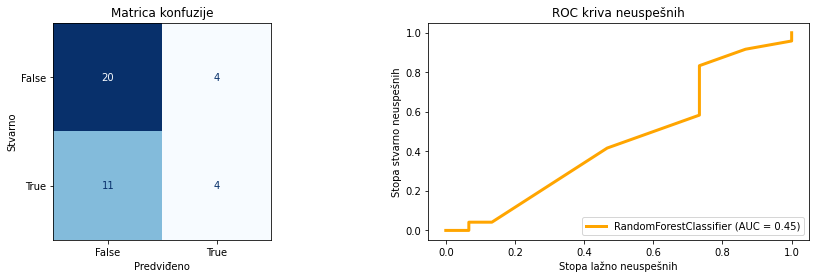

n_estimators: 10 , max_samples:75
              precision    recall  f1-score   support

       False       0.71      0.83      0.77        24
        True       0.64      0.47      0.54        15

    accuracy                           0.69        39
   macro avg       0.68      0.65      0.65        39
weighted avg       0.68      0.69      0.68        39

[0.         0.         0.         0.13333333 0.33333333 0.4
 0.53333333 0.86666667 0.86666667 1.        ]
[0.         0.04166667 0.08333333 0.20833333 0.41666667 0.75
 0.83333333 0.91666667 1.         1.        ]


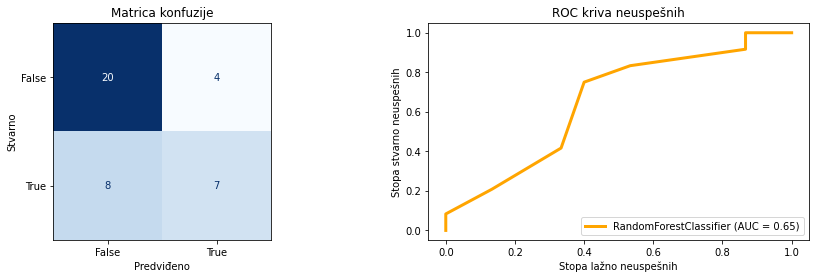

n_estimators: 10 , max_samples:91
              precision    recall  f1-score   support

       False       0.65      0.83      0.73        24
        True       0.50      0.27      0.35        15

    accuracy                           0.62        39
   macro avg       0.57      0.55      0.54        39
weighted avg       0.59      0.62      0.58        39

[0.         0.06666667 0.06666667 0.13333333 0.53333333 0.66666667
 0.73333333 0.93333333 0.93333333 1.        ]
[0.         0.         0.08333333 0.375      0.625      0.79166667
 0.83333333 0.95833333 1.         1.        ]


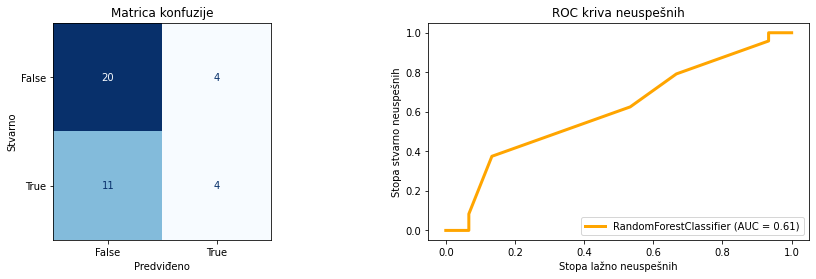

n_estimators: 15 , max_samples:5
              precision    recall  f1-score   support

       False       0.75      0.38      0.50        24
        True       0.44      0.80      0.57        15

    accuracy                           0.54        39
   macro avg       0.60      0.59      0.54        39
weighted avg       0.63      0.54      0.53        39

[0.         0.         0.         0.2        0.4        0.66666667
 0.86666667 1.        ]
[0.         0.04166667 0.125      0.375      0.5        0.875
 0.91666667 1.        ]


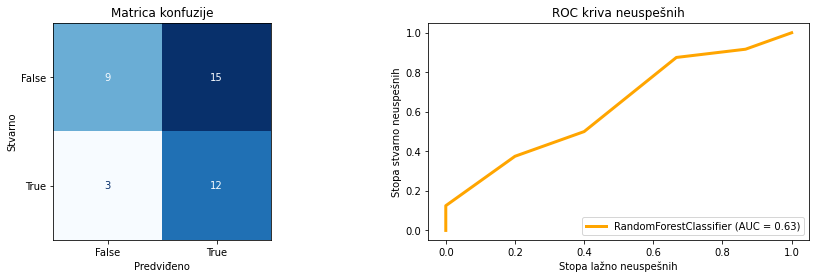

n_estimators: 15 , max_samples:10
              precision    recall  f1-score   support

       False       0.64      0.75      0.69        24
        True       0.45      0.33      0.38        15

    accuracy                           0.59        39
   macro avg       0.55      0.54      0.54        39
weighted avg       0.57      0.59      0.57        39

[0.         0.06666667 0.06666667 0.4        0.46666667 0.6
 0.66666667 0.8        1.        ]
[0.         0.         0.04166667 0.20833333 0.25       0.45833333
 0.75       0.95833333 1.        ]


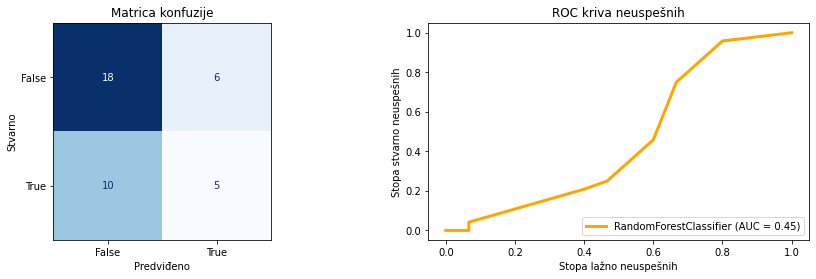

n_estimators: 15 , max_samples:15
              precision    recall  f1-score   support

       False       0.71      0.71      0.71        24
        True       0.53      0.53      0.53        15

    accuracy                           0.64        39
   macro avg       0.62      0.62      0.62        39
weighted avg       0.64      0.64      0.64        39

[0.         0.06666667 0.13333333 0.2        0.26666667 0.46666667
 0.46666667 0.8        0.86666667 1.        ]
[0.         0.04166667 0.08333333 0.16666667 0.375      0.70833333
 0.91666667 1.         1.         1.        ]


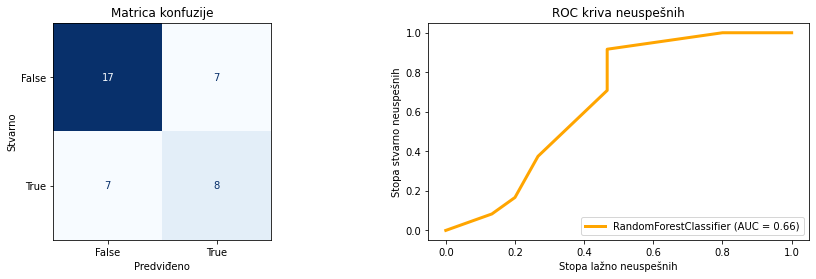

n_estimators: 15 , max_samples:20
              precision    recall  f1-score   support

       False       0.69      0.75      0.72        24
        True       0.54      0.47      0.50        15

    accuracy                           0.64        39
   macro avg       0.62      0.61      0.61        39
weighted avg       0.63      0.64      0.64        39

[0.         0.06666667 0.13333333 0.13333333 0.2        0.33333333
 0.53333333 0.73333333 0.86666667 0.93333333 1.        ]
[0.         0.         0.08333333 0.16666667 0.45833333 0.625
 0.75       0.91666667 0.95833333 1.         1.        ]


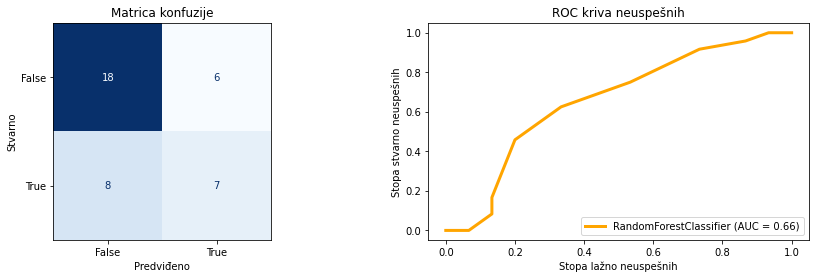

n_estimators: 15 , max_samples:25
              precision    recall  f1-score   support

       False       0.75      0.88      0.81        24
        True       0.73      0.53      0.62        15

    accuracy                           0.74        39
   macro avg       0.74      0.70      0.71        39
weighted avg       0.74      0.74      0.73        39

[0.         0.06666667 0.06666667 0.06666667 0.13333333 0.46666667
 0.73333333 0.93333333 1.         1.        ]
[0.         0.         0.16666667 0.375      0.625      0.875
 0.91666667 0.95833333 0.95833333 1.        ]


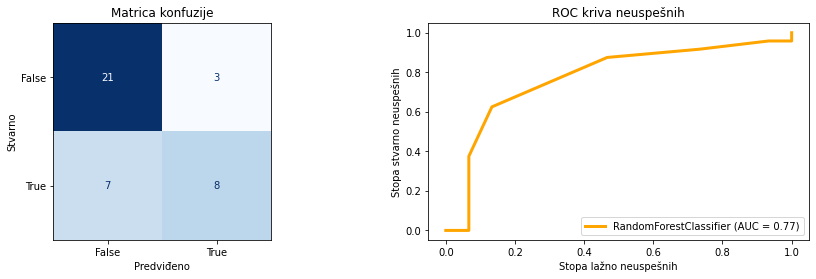

n_estimators: 15 , max_samples:50
              precision    recall  f1-score   support

       False       0.66      0.79      0.72        24
        True       0.50      0.33      0.40        15

    accuracy                           0.62        39
   macro avg       0.58      0.56      0.56        39
weighted avg       0.60      0.62      0.60        39

[0.         0.13333333 0.13333333 0.2        0.4        0.46666667
 0.66666667 0.86666667 0.93333333 1.         1.        ]
[0.         0.         0.04166667 0.25       0.41666667 0.58333333
 0.79166667 0.91666667 0.95833333 0.95833333 1.        ]


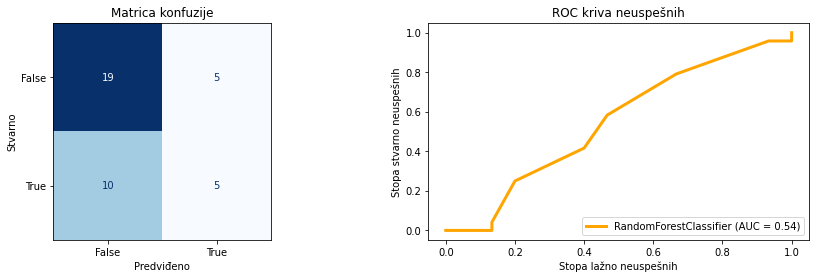

n_estimators: 15 , max_samples:75
              precision    recall  f1-score   support

       False       0.73      0.79      0.76        24
        True       0.62      0.53      0.57        15

    accuracy                           0.69        39
   macro avg       0.67      0.66      0.67        39
weighted avg       0.69      0.69      0.69        39

[0.         0.         0.         0.06666667 0.13333333 0.2
 0.4        0.46666667 0.6        0.8        0.8        0.93333333
 1.        ]
[0.         0.04166667 0.125      0.16666667 0.29166667 0.54166667
 0.70833333 0.79166667 0.83333333 0.875      1.         1.
 1.        ]


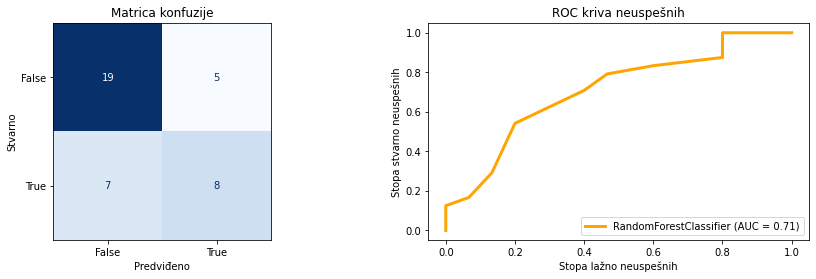

n_estimators: 15 , max_samples:91
              precision    recall  f1-score   support

       False       0.61      0.83      0.70        24
        True       0.33      0.13      0.19        15

    accuracy                           0.56        39
   macro avg       0.47      0.48      0.45        39
weighted avg       0.50      0.56      0.51        39

[0.         0.06666667 0.06666667 0.06666667 0.06666667 0.2
 0.4        0.66666667 0.86666667 0.86666667 0.93333333 1.        ]
[0.         0.         0.04166667 0.125      0.29166667 0.41666667
 0.625      0.75       0.83333333 0.91666667 1.         1.        ]


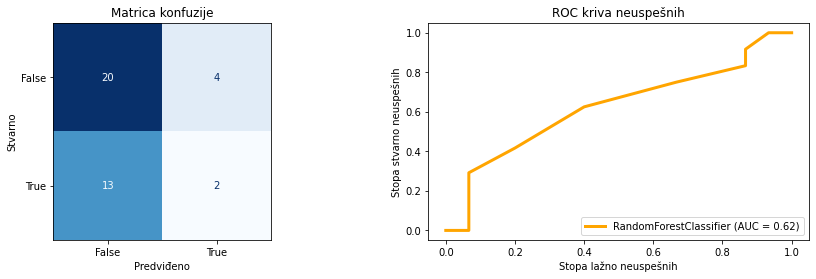

In [14]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_ = [2, 5, 10, 15]
max_samples_ = [5, 10,15, 20, 25, 50, 75, 91]

for n_estimators in n_estimators_:
    for max_samples in max_samples_:
        print("n_estimators: {} , max_samples:{}".format(n_estimators, max_samples))
        model = RandomForestClassifier(random_state=0,
                                        bootstrap=True, 
                                        n_estimators=n_estimators,
                                        max_samples=max_samples,
                                        class_weight='balanced')
        klasifikuj(X, Y, model)


              precision    recall  f1-score   support

       False       0.58      0.62      0.60        24
        True       0.31      0.27      0.29        15

    accuracy                           0.49        39
   macro avg       0.44      0.45      0.44        39
weighted avg       0.47      0.49      0.48        39

[0.         0.06666667 0.2        0.26666667 0.4        0.73333333
 0.8        0.86666667 0.93333333 1.        ]
[0.         0.         0.125      0.33333333 0.54166667 0.625
 0.83333333 0.95833333 1.         1.        ]


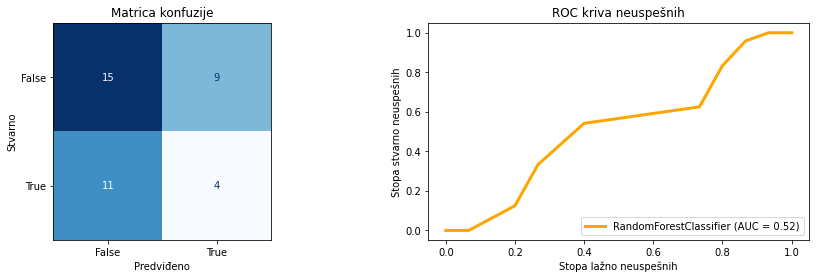

RandomForestClassifier(class_weight={0: 1, 1: 3}, max_samples=20,
                       n_estimators=10, random_state=0)

In [15]:
n_estimators = 10
max_samples = 20

model = RandomForestClassifier(random_state=0,
                                        bootstrap=True, 
                                        n_estimators=n_estimators,
                                        max_samples=max_samples,
                                        class_weight={0:1, 1:3})
klasifikuj(X, Y, model)

## Neuronska mreža

Veštačka neuronska mreža predstavlja simulaciju biološkog nervnog sistema. 
Sastoji se od skupa čvorova i direktnih veza koji simuliraju neurone i sinaptičke veze.
Ako bismo koristili najjednostavniji oblik mreže (perceptron), ne bismo dobili dobre rezultate jer ona koristi hiperravan za razdvajanje podataka na dve klase, a naši podaci nisu najbolje razdvojivi. Iz tog razloga koristimo višeslojnu neuronsku mrežu.

Skaliramo podatke pre primene algoritma, i ponovo tražimo vrednosti parametara koje daju najbolju model. 

Parametri višeslojne mreže: <br>
**hidden_layer_sizes** - broj čvorova u skrivenim slojevima <br>
**activation** - određuje aktivacionu funkciju za skriveni sloj <br>
**solver** - rešavač za optimizaciju težina <br>
**alpha** - regularizacioni parametar, kontroliše preprilagođavanje <br>
**learning_rate** - način na koji se menja stopa učenja kroz iteracije algoritma <br>
**learning_rate_init** - početna vrednost stope/brzine učenja <br>
**power_t** - parametar za slučaj da je stopa učenja inverzno skaliranje <br>

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, stratify=Y, test_size=0.3)    

std_scaler = StandardScaler()  
std_scaler.fit(X_train)  
X_train = std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='sgd',
                    max_iter=350,
                    random_state=0)

params = [{
    'hidden_layer_sizes':[(5,3),(10,5),(20,5)],
    'activation':['relu','tanh','logistic'],
    'alpha':[0.0001,0.0005,0.001, 0.005, 0.01, 0.05],
    'batch_size':[1,5,10,25,50],
    'power_t':[0.2,0.4,0.5,0.6,0.8],
    'learning_rate':['constant','invscaling', 'adaptive'],
    'learning_rate_init':[0.001,0.005,0.01, 0.5]
}]

rscv = RandomizedSearchCV(estimator=clf, 
                          param_distributions=params, 
                          cv=4,
                          refit='balanced_accuracy',
                          scoring= ['roc_auc','balanced_accuracy'])

#X_train, _, Y_train, _ = train_test(X, Y)    
rscv.fit(X_train, Y_train)

/Users/sterlu/opt/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sterlu/opt/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sterlu/opt/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sterlu/opt/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
 

RandomizedSearchCV(cv=4,
                   estimator=MLPClassifier(max_iter=350, random_state=0,
                                           solver='sgd'),
                   param_distributions=[{'activation': ['relu', 'tanh',
                                                        'logistic'],
                                         'alpha': [0.0001, 0.0005, 0.001, 0.005,
                                                   0.01, 0.05],
                                         'batch_size': [1, 5, 10, 25, 50],
                                         'hidden_layer_sizes': [(5, 3), (10, 5),
                                                                (20, 5)],
                                         'learning_rate': ['constant',
                                                           'invscaling',
                                                           'adaptive'],
                                         'learning_rate_init': [0.001, 0.005,
                                  

In [18]:
print(rscv.best_score_)
rscv.best_params_

0.6946924603174603


{'power_t': 0.5,
 'learning_rate_init': 0.01,
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (20, 5),
 'batch_size': 10,
 'alpha': 0.001,
 'activation': 'relu'}

In [19]:
clf = MLPClassifier(solver='lbfgs',
                    max_iter=350,
                    random_state=0)

params = [{
    'hidden_layer_sizes':[(5,3),(10,5),(20,5)],
    'activation':['relu','tanh','logistic'],
    'alpha':[0.0001,0.0005,0.001, 0.005, 0.01, 0.05],
    'batch_size':[1,5,10,25,50],
    'power_t':[0.2,0.4,0.5,0.6,0.8],
    'learning_rate':['constant','invscaling', 'adaptive'],
    'learning_rate_init':[0.001,0.005,0.01, 0.5]
}]

rscv = RandomizedSearchCV(estimator=clf, 
                          param_distributions=params, 
                          cv=4,
                          refit='balanced_accuracy',
                          scoring= ['roc_auc','balanced_accuracy'])

#X_train, _, Y_train, _ = train_test(X, Y)    
rscv.fit(X_train, Y_train)

RandomizedSearchCV(cv=4,
                   estimator=MLPClassifier(max_iter=350, random_state=0,
                                           solver='lbfgs'),
                   param_distributions=[{'activation': ['relu', 'tanh',
                                                        'logistic'],
                                         'alpha': [0.0001, 0.0005, 0.001, 0.005,
                                                   0.01, 0.05],
                                         'batch_size': [1, 5, 10, 25, 50],
                                         'hidden_layer_sizes': [(5, 3), (10, 5),
                                                                (20, 5)],
                                         'learning_rate': ['constant',
                                                           'invscaling',
                                                           'adaptive'],
                                         'learning_rate_init': [0.001, 0.005,
                                

In [20]:
print(rscv.best_score_)
rscv.best_params_

0.6713789682539683


{'power_t': 0.4,
 'learning_rate_init': 0.005,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (10, 5),
 'batch_size': 25,
 'alpha': 0.005,
 'activation': 'logistic'}

Primenili smo model nad nesklairanim i skaliranim podacima i možemo da zaključimo da model pravi manje grešaka kada podaci nisu sklairani.

              precision    recall  f1-score   support

       False       0.74      0.58      0.65        24
        True       0.50      0.67      0.57        15

    accuracy                           0.62        39
   macro avg       0.62      0.62      0.61        39
weighted avg       0.65      0.62      0.62        39

[0.         0.         0.         0.13333333 0.13333333 0.26666667
 0.26666667 0.33333333 0.33333333 0.53333333 0.53333333 0.6
 0.6        0.73333333 0.73333333 0.86666667 0.86666667 1.        ]
[0.         0.04166667 0.16666667 0.16666667 0.20833333 0.20833333
 0.25       0.25       0.58333333 0.58333333 0.625      0.625
 0.875      0.875      0.95833333 0.95833333 1.         1.        ]


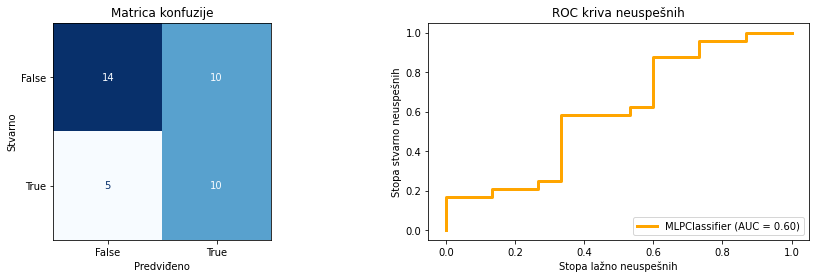

MLPClassifier(activation='logistic', alpha=0.001, batch_size=50,
              hidden_layer_sizes=(20, 5), learning_rate='adaptive',
              learning_rate_init=0.01, power_t=0.2)

In [21]:
model = MLPClassifier(power_t=0.2,
                      learning_rate_init=0.01,
                      learning_rate='adaptive',
                      hidden_layer_sizes=(20, 5),
                      batch_size=50,
                      alpha=0.001,
                      activation='logistic')
                      
klasifikuj(X, Y, model)

              precision    recall  f1-score   support

       False       0.67      0.67      0.67        24
        True       0.47      0.47      0.47        15

    accuracy                           0.59        39
   macro avg       0.57      0.57      0.57        39
weighted avg       0.59      0.59      0.59        39

[0.         0.         0.         0.13333333 0.13333333 0.2
 0.2        0.46666667 0.46666667 0.53333333 0.53333333 0.73333333
 0.73333333 0.8        0.8        1.        ]
[0.         0.04166667 0.16666667 0.16666667 0.33333333 0.33333333
 0.41666667 0.41666667 0.625      0.625      0.79166667 0.79166667
 0.91666667 0.91666667 1.         1.        ]


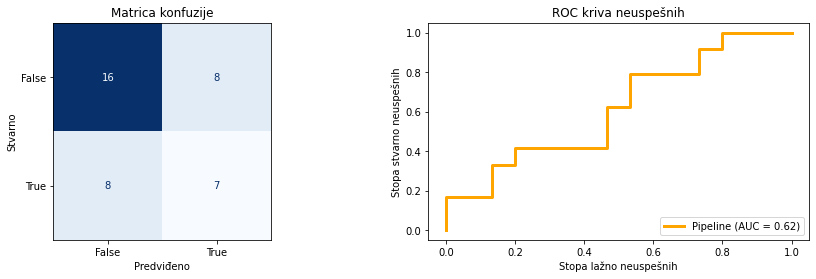

Pipeline(steps=[('std', StandardScaler()),
                ('model',
                 MLPClassifier(activation='logistic', alpha=0.001,
                               batch_size=50, hidden_layer_sizes=(20, 5),
                               learning_rate='adaptive',
                               learning_rate_init=0.01, power_t=0.2))])

In [22]:
model = Pipeline([('std', StandardScaler()), ('model', model)])
klasifikuj(X, Y, model)

## Naivni Bajes

Naivni Bajes dodeljuje instanci onu klasu, za koju je najveća verovatoća da joj instanca pripada. Model radi pod predpostavkom da su atributi nezavisni, pa postoji mogućnost da dobijemo loše rezultate ukoliko postoji veća korelacija među nekim atributima. Koristićemo dva klasifikatora.

### GaussianNB

Prvo ćemo standardizovati podatke, jer ovaj klasifikator pretpostavlja da je raspodela atributa normalna.

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        24
        True       0.38      1.00      0.56        15

    accuracy                           0.38        39
   macro avg       0.19      0.50      0.28        39
weighted avg       0.15      0.38      0.21        39

[0.         0.06666667 0.06666667 0.13333333 0.13333333 0.2
 0.2        0.26666667 0.26666667 0.33333333 0.33333333 0.4
 0.4        0.53333333 0.53333333 0.73333333 0.73333333 1.
 1.        ]
[0.         0.         0.16666667 0.16666667 0.20833333 0.20833333
 0.29166667 0.29166667 0.33333333 0.33333333 0.58333333 0.58333333
 0.66666667 0.66666667 0.79166667 0.79166667 0.91666667 0.91666667
 1.        ]


/Users/sterlu/opt/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sterlu/opt/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sterlu/opt/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

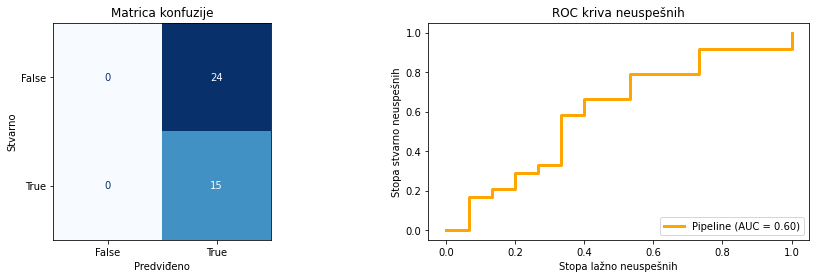

Pipeline(steps=[('std', StandardScaler()), ('gnb', GaussianNB())])

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

model = Pipeline([('std', StandardScaler()), ('gnb', GaussianNB())])
klasifikuj(X, Y, model)

Primenili smo model i na neskaliranim podacima i možemo da vidimo da je kvalitet modela isti ako gledamo ROC krivu, ali da su u slučaju nesklairanih podataka dobrko klasifikovane neke instance obe klase, a ne samo jedne.

              precision    recall  f1-score   support

       False       0.62      0.33      0.43        24
        True       0.38      0.67      0.49        15

    accuracy                           0.46        39
   macro avg       0.50      0.50      0.46        39
weighted avg       0.53      0.46      0.45        39

[0.         0.06666667 0.06666667 0.13333333 0.13333333 0.2
 0.2        0.26666667 0.26666667 0.33333333 0.33333333 0.4
 0.4        0.53333333 0.53333333 0.73333333 0.73333333 1.
 1.        ]
[0.         0.         0.16666667 0.16666667 0.20833333 0.20833333
 0.29166667 0.29166667 0.33333333 0.33333333 0.58333333 0.58333333
 0.66666667 0.66666667 0.79166667 0.79166667 0.91666667 0.91666667
 1.        ]


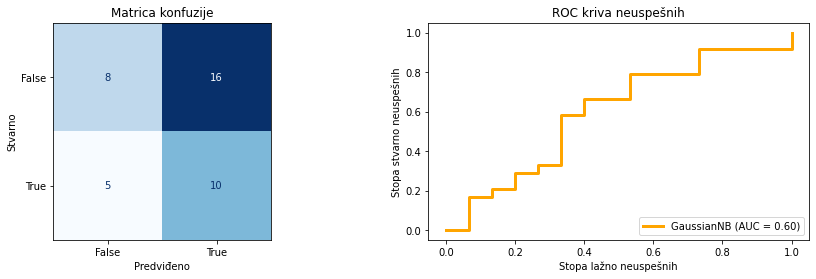

GaussianNB()

In [24]:
model = GaussianNB()
klasifikuj(X, Y, model)

### ComplementNB

Ovaj klasifikator ne radi sa negativnim vrednostima atributa, pa ćemo prvo da skaliramo podatke.

              precision    recall  f1-score   support

       False       0.67      0.50      0.57        24
        True       0.43      0.60      0.50        15

    accuracy                           0.54        39
   macro avg       0.55      0.55      0.54        39
weighted avg       0.58      0.54      0.54        39

[0.         0.06666667 0.06666667 0.13333333 0.13333333 0.26666667
 0.26666667 0.46666667 0.46666667 0.53333333 0.53333333 0.6
 0.6        0.66666667 0.66666667 0.73333333 0.73333333 0.8
 0.8        1.        ]
[0.         0.         0.33333333 0.33333333 0.45833333 0.45833333
 0.5        0.5        0.54166667 0.54166667 0.58333333 0.58333333
 0.66666667 0.66666667 0.83333333 0.83333333 0.91666667 0.91666667
 1.         1.        ]


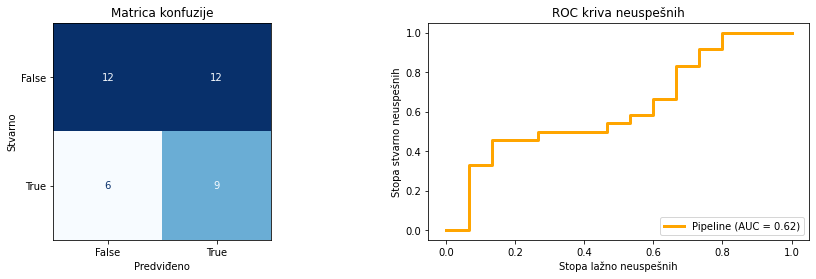

Pipeline(steps=[('mms', MinMaxScaler()), ('cnb', ComplementNB())])

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import ComplementNB

model = Pipeline([('mms', MinMaxScaler()), ('cnb', ComplementNB())])
klasifikuj(X, Y, model)

Ako posmatramo ROC krive modela, možemo da zaključimo da klasifikatori skoro jednako dobro klasifikuju podatke.
Ako posmatramo matricu konfuyije, ComplementNB lošije klasifikuje instance klase False.